In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Open root file with uproot library and get variables from signal and background trees
branch_names = ['jet1_pt', 'jet2_pt', 'jet1_eta', 'jet2_eta', 'jet1_phi', 'jet2_phi', 'jet1_mass', 'jet2_mass', 'm_bb']
file_name = 'data.root'
#Signal Tree
signal_tree = uproot.open(file_name)["signal"]
signal_df = signal_tree.arrays(branch_names, library="pd")
signal_df['class'] = 1
#Background Tree
background_tree = uproot.open(file_name)["background"]
background_df = background_tree.arrays(branch_names, library="pd")
background_df['class'] = 0

In [3]:
#Combine two data as Pandas dataframe and pop up class 
df = pd.concat([signal_df, background_df])
df = df.sample(frac=1).reset_index(drop=True)
y_df = df.pop('class')

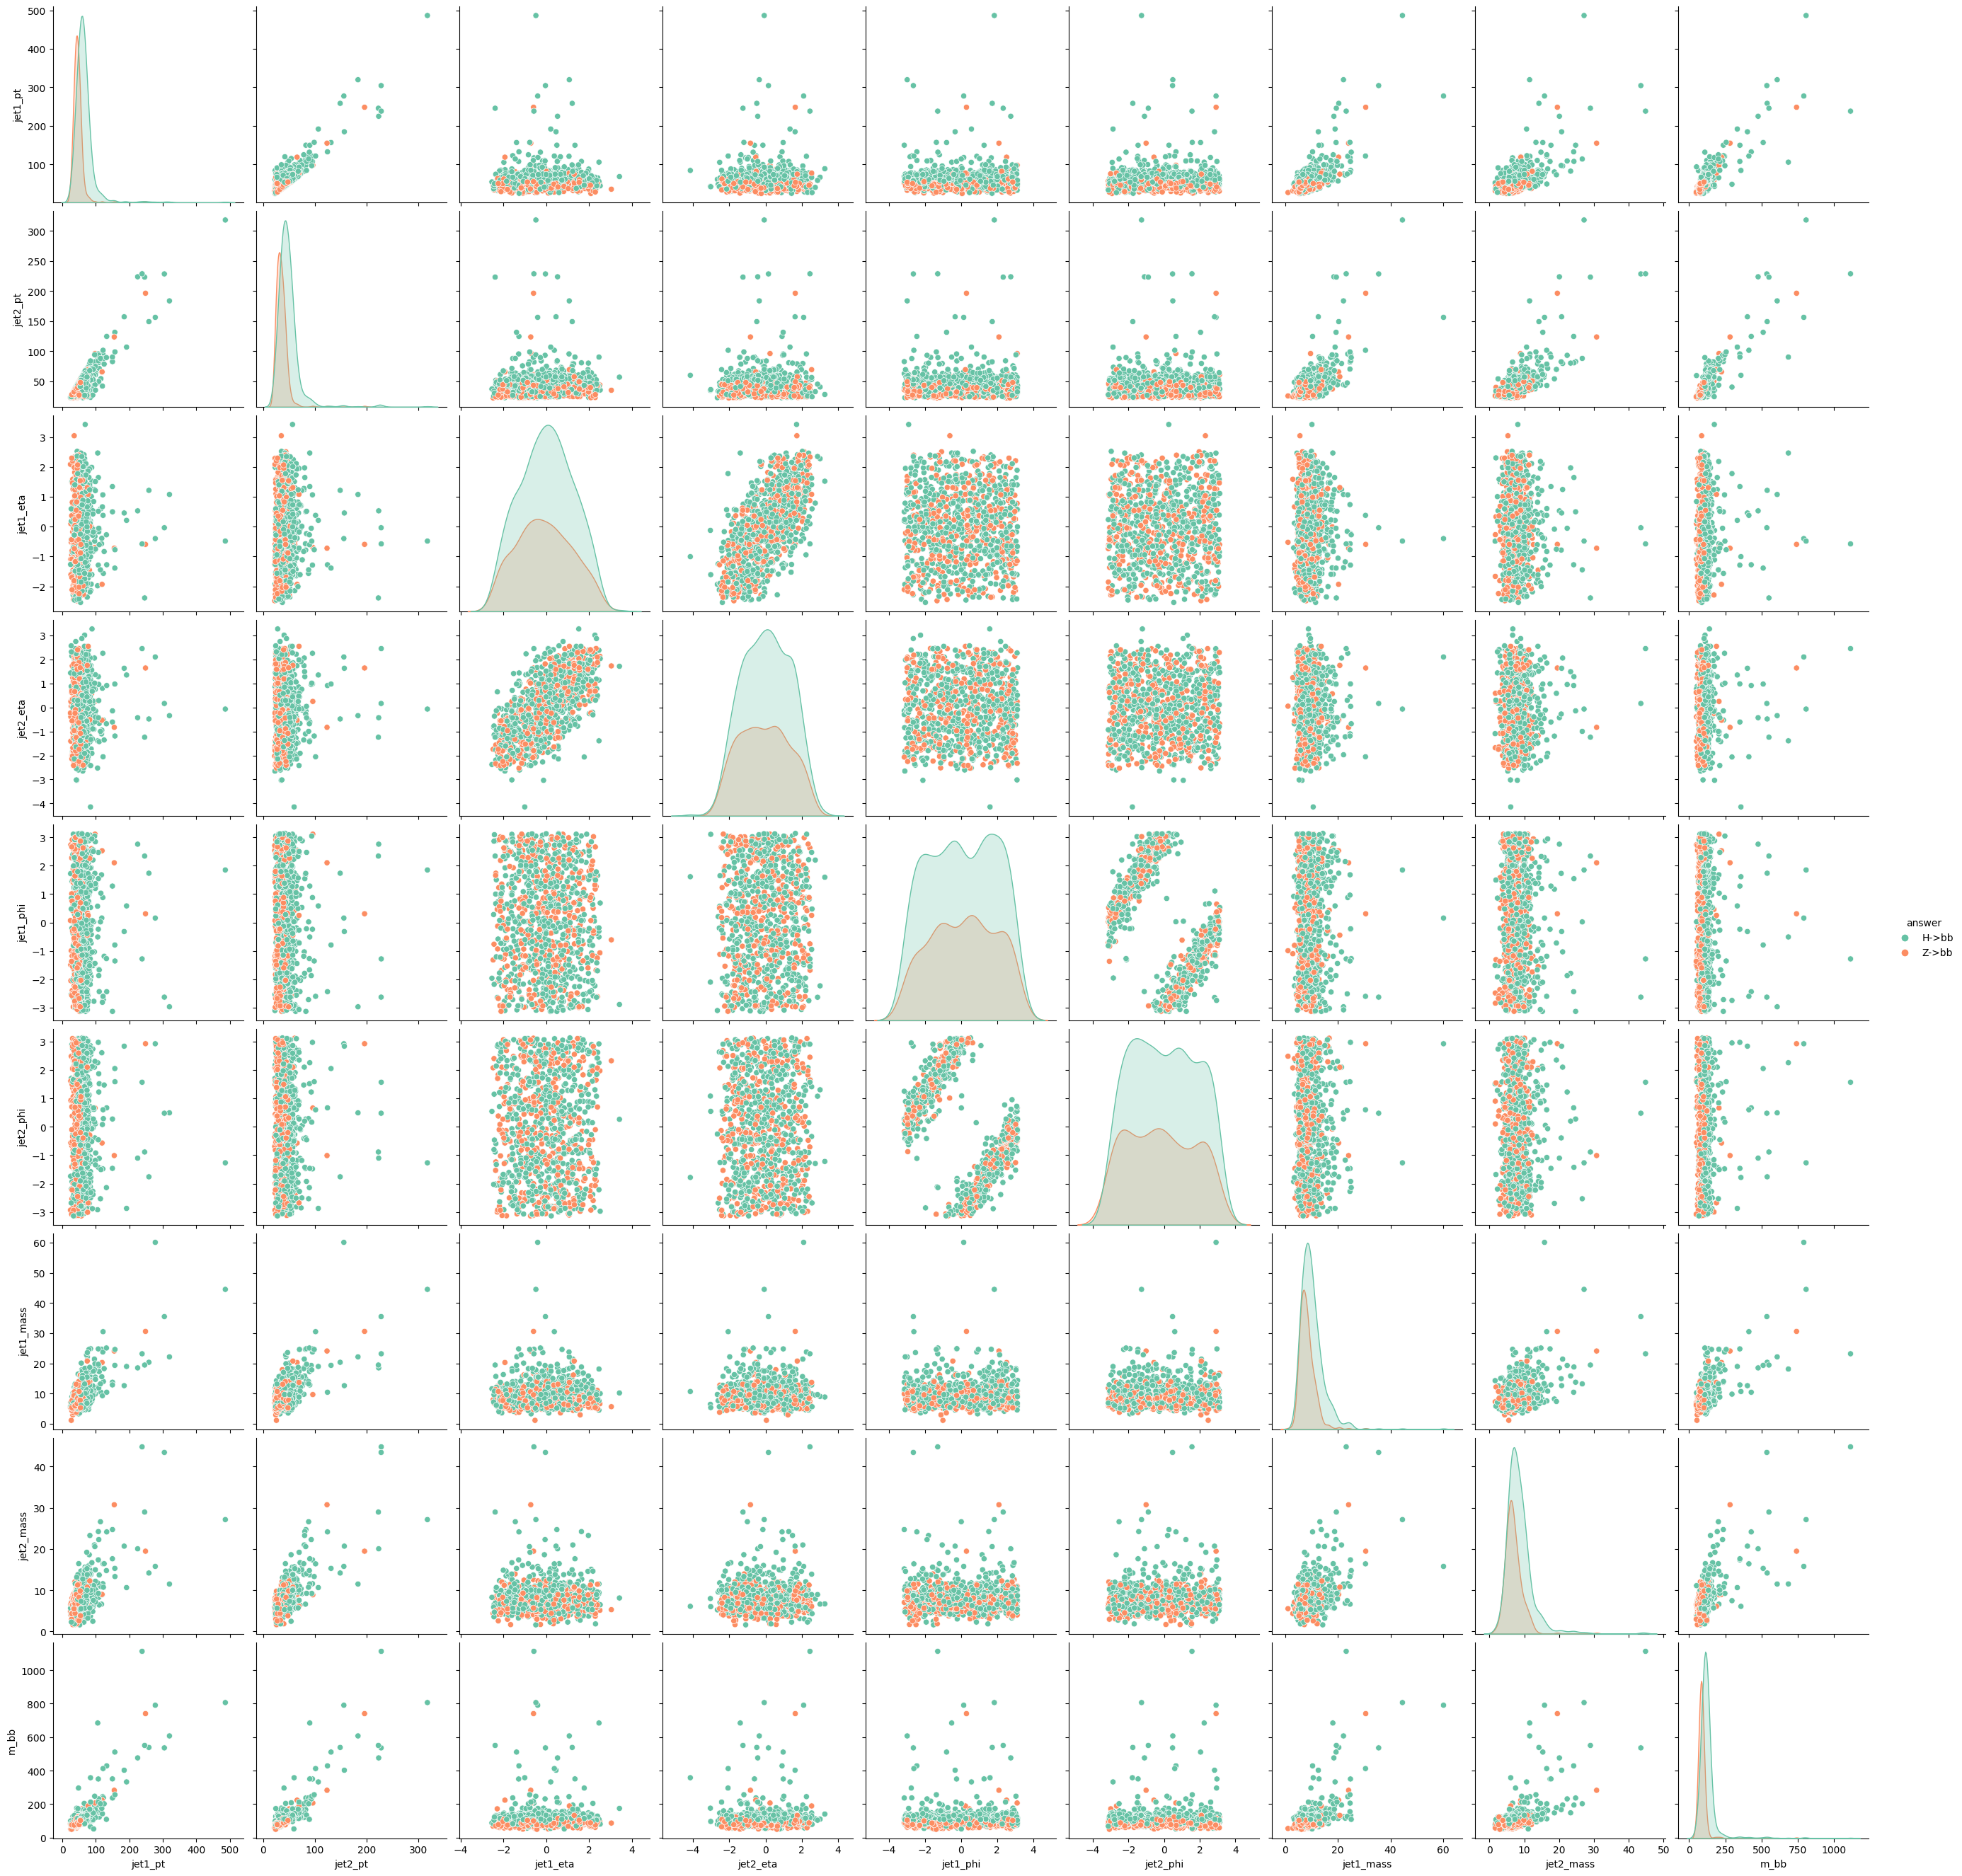

In [4]:
import seaborn as sns
# Seaborn is a nice package for data visualization - it has many pre-defined plotting functions and looks pretty

# Only keep some variables for training
variable_names = ['jet1_pt', 'jet2_pt', 'jet1_eta', 'jet2_eta', 'jet1_phi', 'jet2_phi', 'jet1_mass', 'jet2_mass', 'm_bb']

# Make a new column where the answer is a category with the appropriate name, for plotting
df['answer']='Z->bb'
df.loc[y_df==1,'answer']='H->bb'
df['answer'] = df['answer'].astype('category')
# Plot input distributions and visualize correlations; only look at a subset of events for scatter plotting
graph = sns.pairplot(df.head(1000), vars=variable_names, hue='answer', palette="Set2",height=3) # Diagonal plots are smoothed using kernel density estimator

In [5]:
# Import necessary libraries
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Reduce to only the variables we want to train on, use numpy array format
X = np.array(df[variable_names])
Y = np.array(y_df)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# default: max_depth=2, min_samples_split=2
DTC = DecisionTreeClassifier(max_depth=3,min_samples_split=20)
BDT = AdaBoostClassifier(estimator=DTC,n_estimators=150,algorithm = 'SAMME')

# Train the BDT! One line, very fast
model = BDT.fit(X_train, y_train) # BDT looks at each feature independently, so scaling is typically not necessary

# BDT scores
y_prob_test = model.decision_function(X_test)
# Prediction
y_pred_test = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy: {accuracy * 100:.3f}%")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 79.444%
Confusion Matrix:
[[126  60]
 [ 51 303]]


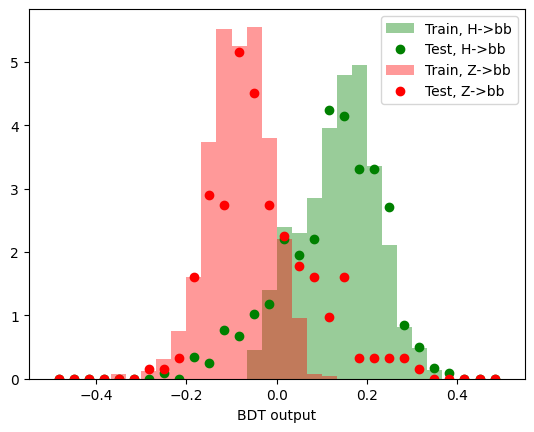

In [6]:
# Extract decision function outputs for signal and background classes in the training set
y_pred_signal_train = model.decision_function(X_train[y_train==1])
y_pred_signal_test = model.decision_function(X_test[y_test==1])
y_pred_background_train = model.decision_function(X_train[y_train==0])
y_pred_background_test = model.decision_function(X_test[y_test==0])

# Set the number of bins, range, and other parameters for the histogram
n_bins = 30
hist_range = (-.5, .5)

# Plot histogram for the signal class in the training set
plt.hist(y_pred_signal_train, bins=n_bins, range=hist_range, density=True, alpha=0.4, color='green', label="Train, H->bb")

# Plot histogram for the signal class in the test set
counts, bin_edges = np.histogram(y_pred_signal_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color='green', label="Test, H->bb")

# Plot histogram for the background class in the training set
plt.hist(y_pred_background_train, bins=n_bins, range=hist_range, density=True, alpha=0.4, color='red', label="Train, Z->bb")

# Plot histogram for the background class in the test set
counts, bin_edges = np.histogram(y_pred_background_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color='red', label="Test, Z->bb")

# Add legend and labels to the plot
plt.legend()
plt.xlabel('BDT output')
#plt.yscale('log')

# Show the plot
plt.show()

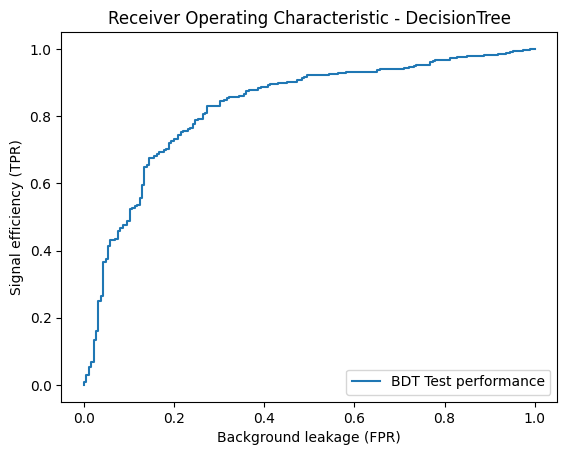

In [7]:
from sklearn.metrics import roc_curve
# Compute ROC curve for the Boosted Decision Tree (BDT) model using the test set
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y_test, y_prob_test, pos_label=1)

# Plot the ROC curve for the BDT model
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT Test performance")

# Add title and axis labels to the plot
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

# Add legend to the plot
plt.legend(loc="lower right")

# Show the plot
plt.show()

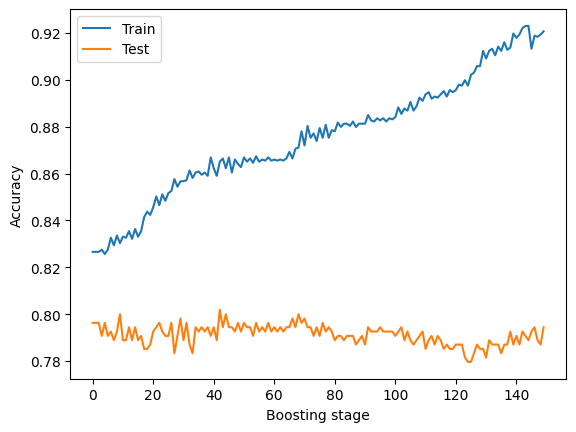

In [8]:
# Initialize empty lists to store training and testing accuracy at each boosting stage
test_acc, train_acc = [], []

# Iterate through each boosting stage and collect accuracy scores for training set predictions
for train_predict in model.staged_predict(X_train):
    train_acc.append(accuracy_score(train_predict, y_train))
    
# Iterate through each boosting stage and collect accuracy scores for test set predictions
for test_predict in model.staged_predict(X_test):
    test_acc.append(accuracy_score(test_predict, y_test)) 

# Plot the training and testing accuracy over boosting stages
plt.plot(train_acc, label="Train")  # Plot training accuracy
plt.plot(test_acc, label="Test")    # Plot testing accuracy
plt.xlabel("Boosting stage")         # Label for the x-axis
plt.ylabel("Accuracy")               # Label for the y-axis
plt.legend()                         # Add legend to distinguish between training and testing accuracy
plt.show()


[0.93615786] [0.17864476] [-0.00983118]


/var/folders/h1/s46zdkz905j6q1vd7vxjj6v40000gn/T/ipykernel_63414/216977263.py:20: RuntimeWarning: invalid value encountered in divide
  metric = S / np.sqrt(S + B)


<Figure size 500x500 with 0 Axes>

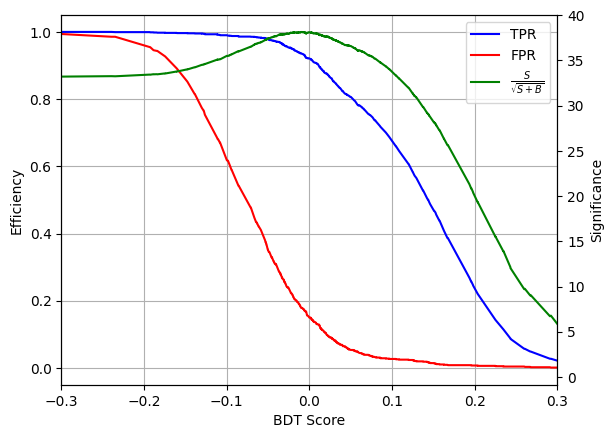

In [9]:
# Obtain decision function scores for all samples in the dataset
y_predict = model.decision_function(X)

# Extract true labels from the dataset
y_data = Y

# Determine the event sizes for signal and background classes
signal_eventsize = len(X[Y == 1])
background_eventsize = len(X[Y == 0]) 

# Compute ROC curves for both signal and background classes
signal_FPR, signal_TPR, signal_BDT_Score = roc_curve(y_data, y_predict, pos_label=1)  # Signal class set to 1
background_FPR, background_TPR, background_BDT_Score = roc_curve(y_data, y_predict, pos_label=0)  # Background class set to 0

# Calculate the Signal (S) and Background (B) contributions for significance metric
S = signal_eventsize * signal_TPR
B = background_eventsize * signal_FPR

# Calculate the significance metric S / sqrt(S + B) at each BDT score
metric = S / np.sqrt(S + B)

# Find the maximum significance and corresponding signal and background efficiencies and BDT score cut
max_metric = np.nanmax(metric)
signal_eff_max_metric = signal_TPR[np.where(metric == np.nanmax(metric))]
background_eff_max_metric = signal_FPR[np.where(metric == np.nanmax(metric))]
score_cut = signal_BDT_Score[np.where(metric == np.nanmax(metric))]

# Print the results
print(signal_eff_max_metric, background_eff_max_metric, score_cut)

# Create a plot to visualize the ROC curve, signal and background efficiencies, and significance metric
plt.figure(figsize=(5, 5))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel('BDT Score')
ax1.set_ylabel('Efficiency')
ax2.set_ylabel('Significance')

# Plot the True Positive Rate (TPR) and False Positive Rate (FPR) on the left y-axis
lns1 = ax1.plot(signal_BDT_Score, signal_TPR, 'b-', label="TPR")
lns2 = ax1.plot(signal_BDT_Score, signal_FPR, 'r-', label="FPR")

# Plot the significance metric on the right y-axis
lns3 = ax2.plot(signal_BDT_Score, metric, 'g-', label='$\\frac{S}{\\sqrt{S+B}}$')

# Add gridlines to the plot
ax1.grid()

# Combine all lines and labels for legend
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

# Set x-axis limits for better visualization
plt.xlim(-0.3, 0.3)

# Display the plot
plt.show()

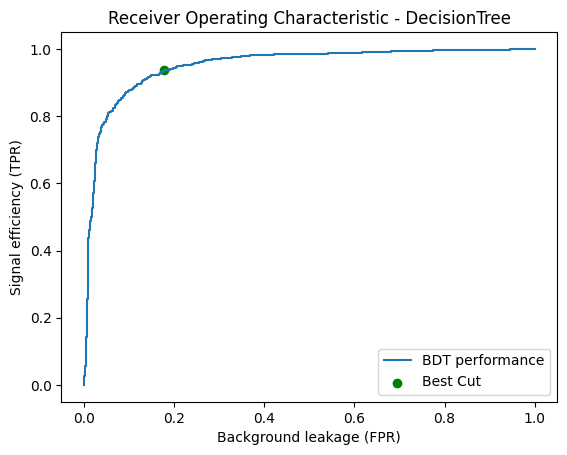

In [10]:
# Obtain decision function scores for all samples in the dataset
Y_prob_all = model.decision_function(X)

# Compute ROC curve for the Boosted Decision Tree (BDT) model using the entire dataset
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(Y, Y_prob_all, pos_label=1)  # Signal class set to 1

# Plot the ROC curve for the BDT model
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")

# Scatter plot to highlight the point corresponding to the best cut (maximized significance)
plt.scatter(background_eff_max_metric, signal_eff_max_metric, c='green', label="Best Cut")

# Add title and axis labels to the plot
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

# Add legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

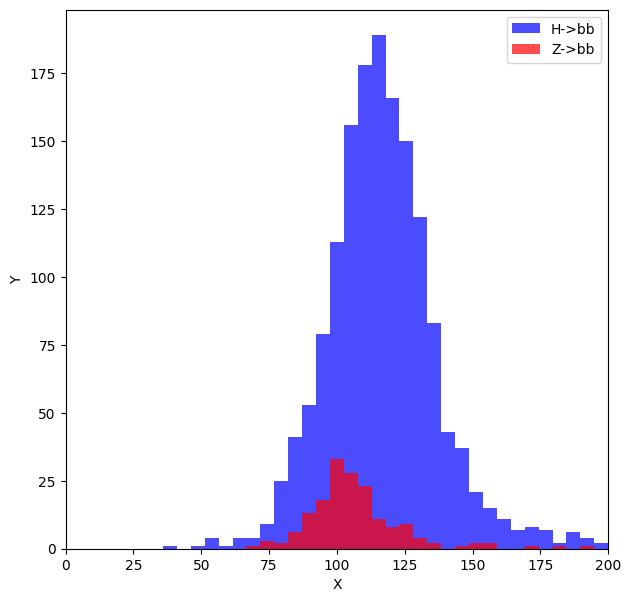

In [14]:
# Concatenate original features (X), true labels (Y), and predicted decision function scores (y_predict)
analyzed_data = np.hstack((X, Y.reshape(-1, 1)))
analyzed_data = np.hstack((analyzed_data, y_predict.reshape(-1, 1)))
# Select rows where the decision function score is greater than the previously determined score cut
signal = analyzed_data[analyzed_data[:, len(variable_names)] == 1]
signal_cut = signal[signal[:, len(variable_names)+1] > score_cut]

# Select rows where the decision function score is greater than the previously determined score cut
background = analyzed_data[analyzed_data[:, len(variable_names)] == 0]
background_cut = background[background[:, len(variable_names)+1] > score_cut]

common_bins = np.linspace(0, 200, num=40)
# Create histograms for signal and background
plt.figure(1, figsize=(7, 7))
plt.hist(signal_cut[:, len(variable_names)-1], bins=common_bins, color='blue', alpha=0.7, label='H->bb')
plt.hist(background_cut[:, len(variable_names)-1], bins=common_bins, color='red', alpha=0.7, label='Z->bb')
plt.xlim(0, 200)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

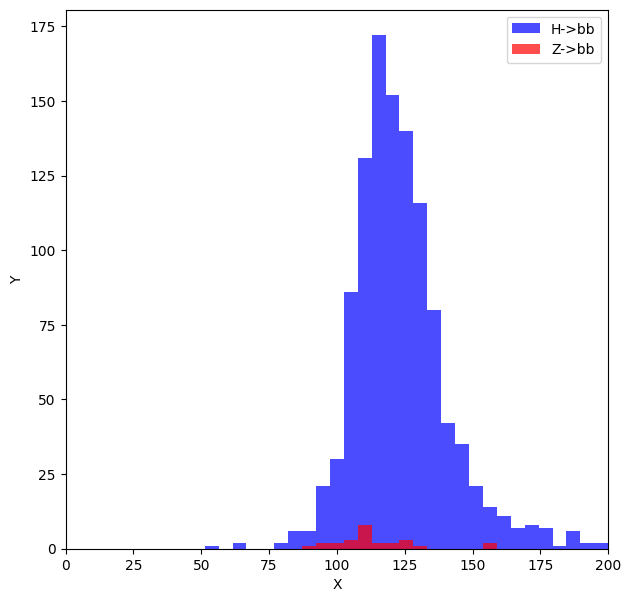

In [13]:
# Concatenate original features (X), true labels (Y), and predicted decision function scores (y_predict)
analyzed_data = np.hstack((X, Y.reshape(-1, 1)))
analyzed_data = np.hstack((analyzed_data, y_predict.reshape(-1, 1)))
# Select rows where the decision function score is greater than the previously determined score cut
signal = analyzed_data[analyzed_data[:, len(variable_names)] == 1]
signal_cut = signal[signal[:, len(variable_names)+1] > 0.1]

# Select rows where the decision function score is greater than the previously determined score cut
background = analyzed_data[analyzed_data[:, len(variable_names)] == 0]
background_cut = background[background[:, len(variable_names)+1] > 0.1]

common_bins = np.linspace(0, 200, num=40)
# Create histograms for signal and background
plt.figure(1, figsize=(7, 7))
plt.hist(signal_cut[:, len(variable_names)-1], bins=common_bins, color='blue', alpha=0.7, label='H->bb')
plt.hist(background_cut[:, len(variable_names)-1], bins=common_bins, color='red', alpha=0.7, label='Z->bb')
plt.xlim(0, 200)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()